# Poker Parser

Welcome to the Poker Parser. This works with data downloaded from the log at the end of a game at pokernow.com.

## Instructions

- Within the data folder, create a subfolder for each of your poker groups. This enables the notebook to get the lifetime performance metrics of a group.
- At the end of a game, download the log and place it in the data subfolder for that group. Give the file the name `data_dd_mm_yy.csv`, where dd, mm, yy are replaced by the day, month, and year respectively.
- Go through this script and change the things marked with a markdown comment starting with an exclaimation mark (**!**). 

## Import functions

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import winnings_analysis, rounds_analysis
from datetime import datetime

- **!** -- Change `date` here to the date of your most recent game. Alternatively, if the game was today, you can leave it as "auto".
- This date sets the data file to look for, as well as the folder to send the results to.
- **!** -- Change `group` to the name of the poker group containing your game. This is used both for loading this data, as well as producing the lifetime plots later.

In [2]:
date = '11_03_21'
if date=='auto':
    date = datetime.now().strftime("%d_%m_%y")
    
group = 'sheff_crew'

## Load and process data

- This loads the data, and finds the names of the participants in the raw data file. At any point you can call dfraw to see the raw data.

In [3]:
dfraw = pd.read_csv(f'../data/{group}/data_{date}.csv').reset_index(drop=True)

names = winnings_analysis.get_names(dfraw)
df = winnings_analysis.get_totals(dfraw, names)

- Creates the output subfolder in ./figures.

In [4]:
fig_folder = '../figures/' + date
if not os.path.exists(fig_folder):
    os.mkdir(fig_folder)

## Colour tester

- **!** -- Use this to determine the colour scheme for your players. You can change `randomise` to `True` to choose random colours, leave it as `False` to use the default colour scheme, or un-comment some of the suggestions at the bottom. 

['#1f77b4', '#ff7f0e', '#2ca02c'] 



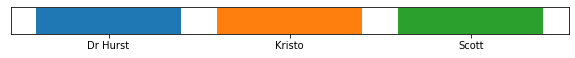

In [5]:
randomise = False

from matplotlib import colors as mcolors
cols = list(mcolors.CSS4_COLORS.keys())
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
cols = [c for c in cols if 'white' not in c]

if randomise:
    np.random.shuffle(cols)

plt.figure(figsize=[10,0.5])
for i,n in enumerate(names):
    plt.bar([names[i]], [1], color=cols[i])
    plt.xticks(rotation=0);
    plt.yticks([]);
print(cols[:len(names)], '\n')

# Some good colour schemes
# cols = ['mediumturquoise', 'grey', 'red', 'darkmagenta']
# cols = ['forestgreen', 'orange', 'purple', 'cornflowerblue']
# cols = ['darkmagenta', 'forestgreen', 'coral', 'darkturquoise','grey']

## Total bankroll over time

- This section plots the total stacks of each player through the game.

In [8]:
def plot_bankroll(df_totals, names, fig_folder, filename, plot=False):
    plt.figure(figsize=[15,10])
    sns.set(font_scale=2)
    for i,n in enumerate(names):
        plt.plot(np.arange(1,len(df_totals)+1),df_totals[n].values,label=n,color=cols[i],linewidth=4)
    plt.legend()
    plt.xlabel('Round number')
    plt.ylabel('£££')
    plt.xlim(left=0);
    plt.gca().axhline(0,dashes=[3,6],linewidth=.5,color='black')
    plt.gca().axhline(df.loc[0,names[0]],dashes=[3,6],linewidth=.5,color='black')

    if plot:
        savepath = os.path.join(fig_folder, filename)
        plt.savefig(savepath,bbox_inches='tight')

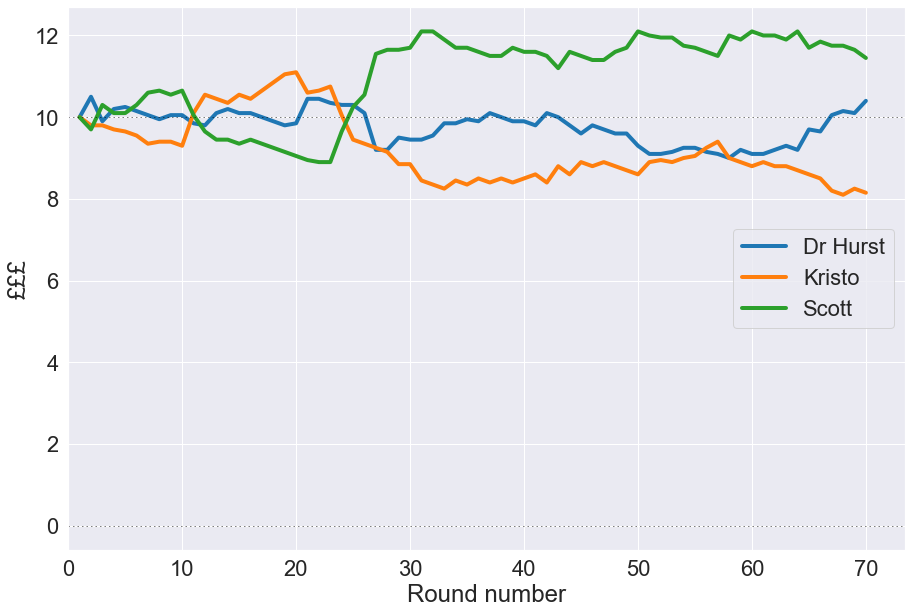

In [36]:
plot_bankroll(df, names, fig_folder=fig_folder, filename='bankroll.png', plot=True)

## Winnings and losses per round

- Here we can see the winnings of each player. Each vertical bar represents one hand. The colour above the axis shows who won the hand and by how much. This is matched in size by a number of bars below the axis, with colours showing who lost and by how much.

In [41]:
def plot_winnings(df, names, fig_folder, filename, plot=False):
    plt.figure(figsize=[20,10])
    sns.set(font_scale=2)

    previous = (np.arange(1,len(df))*0).astype(float)
    max_ = 0
    for i,n in enumerate(names):
        diffs = np.diff(df[n])

        above_part = np.where(diffs>0, diffs, 0)
        max_ = max(max_, max(above_part))
        plt.bar(np.arange(1,len(df)),above_part,color=cols[i], label=n, alpha=1)

        bottom_part = np.diff(df[n])
        bottom_part = np.where(diffs<0, -diffs, 0)
        previous-=bottom_part

        inds = np.where(bottom_part!=0)[0]
        y_plot = bottom_part[inds]
        x_plot = np.arange(1,len(df))[inds] 
        plt.bar(x_plot,y_plot,bottom=previous[inds],color=cols[i], alpha=1)


    plt.legend(loc=[0.82,.77])
    plt.xlabel('Round number')
    plt.ylabel('Winnings')

    plt.ylim((-max_*1.1,max_*1.1));
    
    if plot:
        savepath = os.path.join(fig_folder, filename)
        plt.savefig(savepath,bbox_inches='tight')    

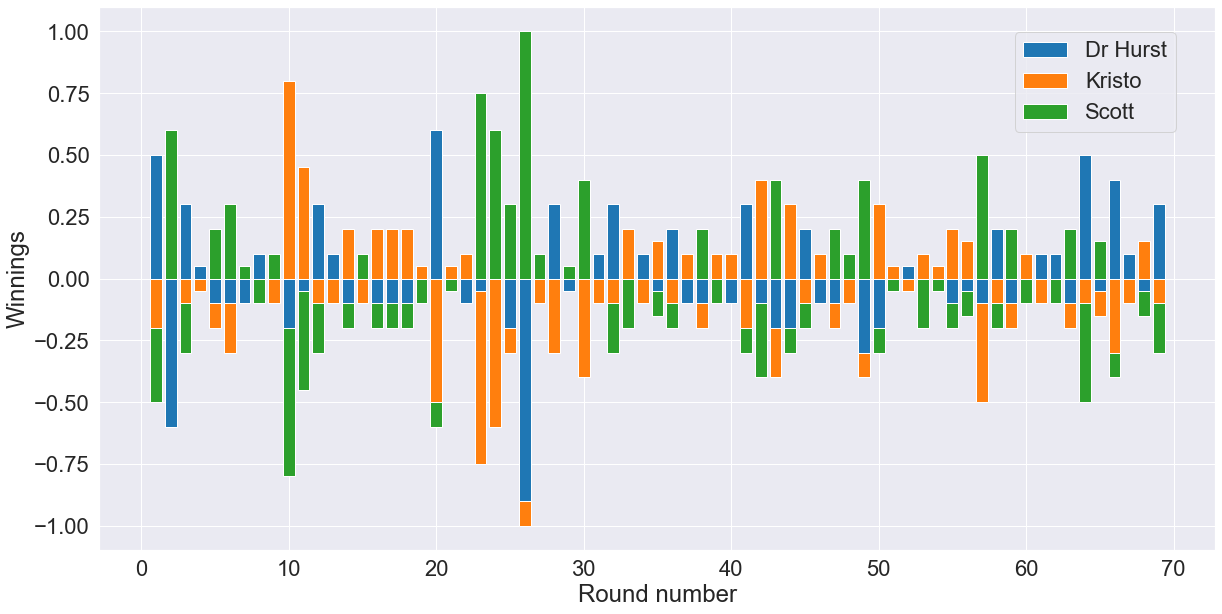

In [42]:
plot_winnings(df, names, fig_folder=fig_folder, filename='winnings.png', plot=True)

## Who won at which parts?

- **!** -- These functions get the parts of the hand at which people won. i.e. the pre-flop, flop, turn, or river.

In [43]:
win_on, win_on_perc = rounds_analysis.get_round_wins(dfraw, names)

In [44]:
def bar_plotter(df, save=True, fig_folder=None, ylabel='', filename=None, width=10):
    fig = plt.figure(figsize=(width,5))
    sns.set(font_scale=2)
    
    rounds = [c for c in df.columns if c!='Name']
    names = list(df['Name'].values)
    
    main_ticks = np.arange(len(rounds))
    jump = 1/(len(names)+1)
    
    for i, n in enumerate(names):
        xpos = main_ticks + jump*i
        
        data_to_plot = [df.loc[df['Name']==n, r].values[0] for r in rounds]
        
        plt.bar(
            xpos,
            data_to_plot,
            width=jump*0.9,
            label=n.title(),
            color=cols[i]
        )
        
    plt.ylabel(ylabel)
        
    plt.gca().set_xticks(main_ticks + jump*(i/2))
    plt.gca().set_xticklabels(rounds)
    legend = plt.legend(title='Player', loc=[0.45,0.3])
    plt.setp(legend.get_title(),fontsize=15)
    plt.grid(axis='x')
    if save:
        plt.savefig(os.path.join(fig_folder, filename),bbox_inches='tight')
    return

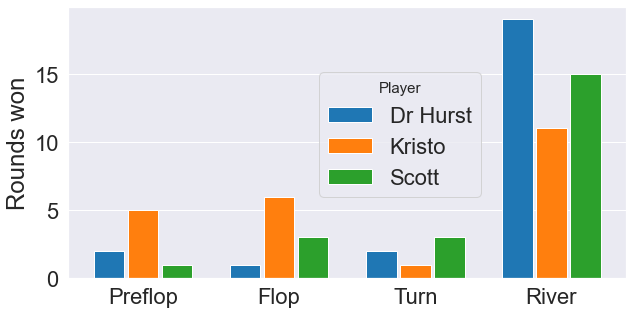

In [45]:
bar_plotter(win_on, save=True, ylabel='Rounds won', fig_folder=fig_folder, filename='abs_rounds.png')

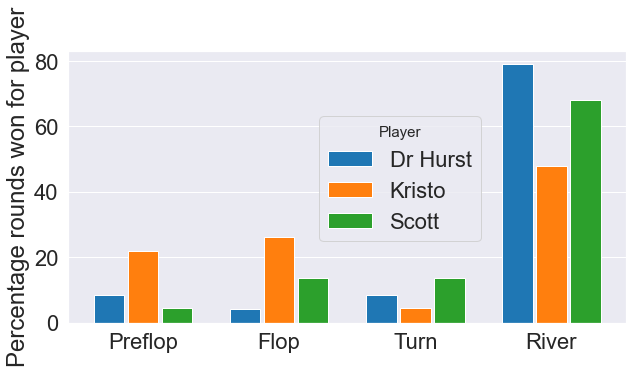

In [46]:
bar_plotter(win_on_perc, save=True, ylabel='Percentage rounds won for player', fig_folder=fig_folder, filename='perc_rounds.png')

## Which hands did people win with?

- This is similar to the graph above, but with the pre-river hands conbined into one section, and the river hands expanded. That is to say, we see what hands people had when they made their money. A person's bar on a given hand increases if they showed that hand at the river to win. If they won the hand by everyone else filding, the first bar increases.

In [47]:
df_showdown = winnings_analysis.get_showdown_hands(dfraw, names)

In [48]:
def col_renamer(df_):
    df = df_.copy()
    df = df.rename(columns={
    'fold':'Others\nFolded',
    'high':'High\nCard',
    'pair':'Pair',
    'two pair':'Two\nPair',
    'three of a kind':'Three\nof a\nKind',
    'straight':'Straight',
    'flush':'Flush',
    'full house':'Full\nHouse',
    'four of a kind':'Four\nof a\nKind',
    'straight flush':'Straight\nFlush',
    'royal flush':'Royal\nFlush',
    })
    return df

In [49]:
df_showdown = col_renamer(df_showdown)

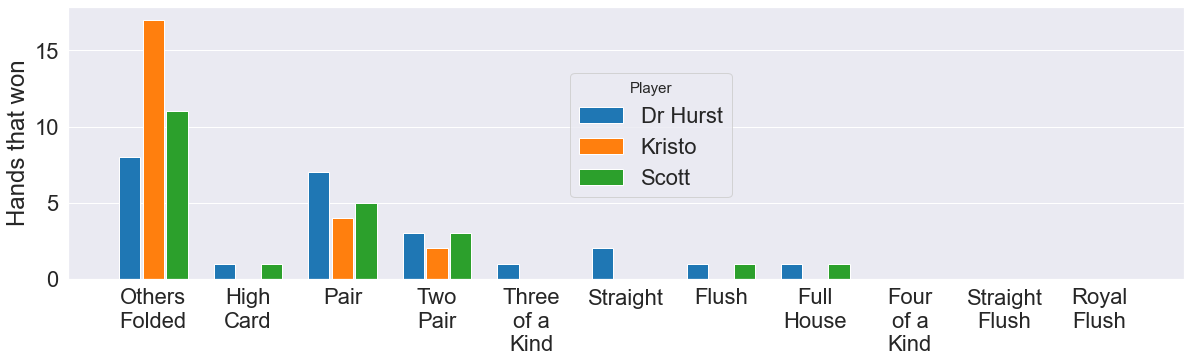

In [51]:
bar_plotter(df_showdown, save=True, fig_folder=fig_folder, ylabel='Hands that won', filename='showdown.png', width=20)

# Lifetime stats

- This section allows us to plot performance week-on-week for a regualar poker group. In order to use this, please make sure that all relevant data files are stored in a `data` subdirectory with the proper naming format.

In [52]:
#Get the datafiles

datalist = [f for f in os.listdir(f'../data/{group}') if 'data' in f]

datalist = [x[5:-4] for x in datalist]
datalist = sorted(datalist, key = lambda x: datetime.strptime(x, '%d_%m_%y'))
datalist = ['data_'+x+'.csv' for x in datalist]

dfall = [pd.read_csv(f'../data/{group}/{x}') for x in datalist]

- It may be the case that people have used different in-game nicknames in their games. However, we want to consider these as the same person from the position of plotting stats.
- **!** -- You should edit the variable `namegroups` below to account for this. This should be a list of lists. Each sublist is a list of known aliases for a single person. The first name in each sublist will be used in the legends of the graphs.
- The variable `allnames` may halp with this. It is a list of all nicknames used in your group.

In [ ]:
allnames = list(set([item for sublist in [winnings_analysis.get_names(d) for d in dfall] for item in sublist]))

In [53]:
# Get all available names. We should manually group these into a list of lists.

namegroups = [
    ['Scott','Scottyboi','Dr Scott','Dr. Scott'],
    ['David','Dr Hurst','Dr. Hurst'],
    ['Kristo','kris','Kris','Also a DR','Krist','kristo'],
    ['Mike','Michael','Dr. Roche']
]

lifetimenames = [n[0] for n in namegroups]

## Lifetime bankroll

- This is the total stack over time, including all wins and losses. This starts at zero, giving relative profits and losses.

In [54]:
lifetimedf = winnings_analysis.get_lifetime_performance(dfall, namegroups)

17/17


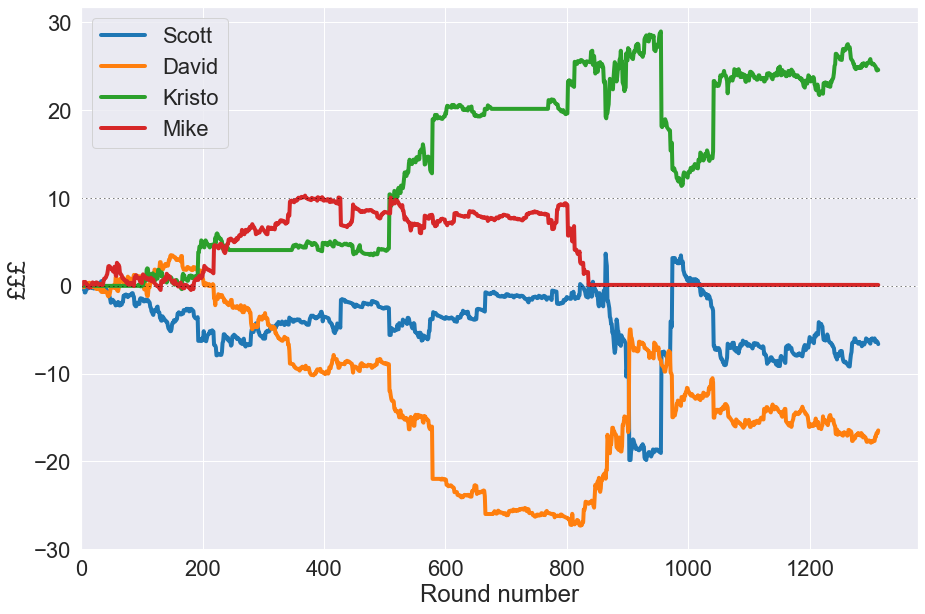

In [55]:
plot_bankroll(lifetimedf, lifetimenames, fig_folder=fig_folder, filename='lifetime_bankroll.png', plot=True)

## Lifetime showdown

In [56]:
for i in range(len(dfall)):
    dfall[i] = winnings_analysis.unify_names(dfall[i], namegroups)

In [57]:
for i, dfraw_i in enumerate(dfall):
    print(f'\r{i+1}', end='')
    df_showdown = winnings_analysis.get_showdown_hands(dfraw_i, lifetimenames)
    nonname = [c for c in df_showdown.columns if c!='Name']
    if i==0:
        dfsl = df_showdown
    else:
        dfsl[nonname] = dfsl[nonname] + df_showdown[nonname]
dfsl = dfsl.reset_index(drop=1)

17

In [59]:
dfsl_perc = dfsl.copy()
dfsl_perc[nonname] = 100*np.divide(dfsl_perc[nonname].values, dfsl_perc[nonname].sum(axis=1).values.reshape(len(lifetimenames), -1))

dfsl = col_renamer(dfsl)
dfsl_perc = col_renamer(dfsl_perc)

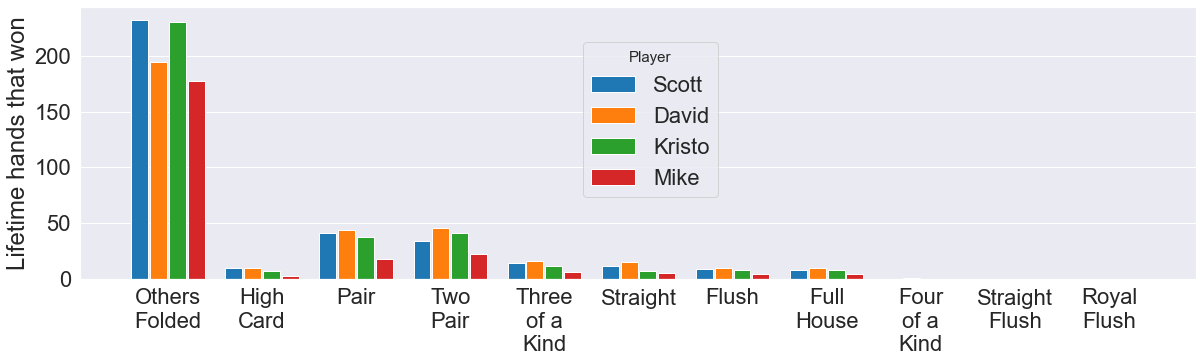

In [60]:
bar_plotter(dfsl, save=True, fig_folder=fig_folder, ylabel='Lifetime hands that won', filename='abs_lifetime_showdown.png', width=20)

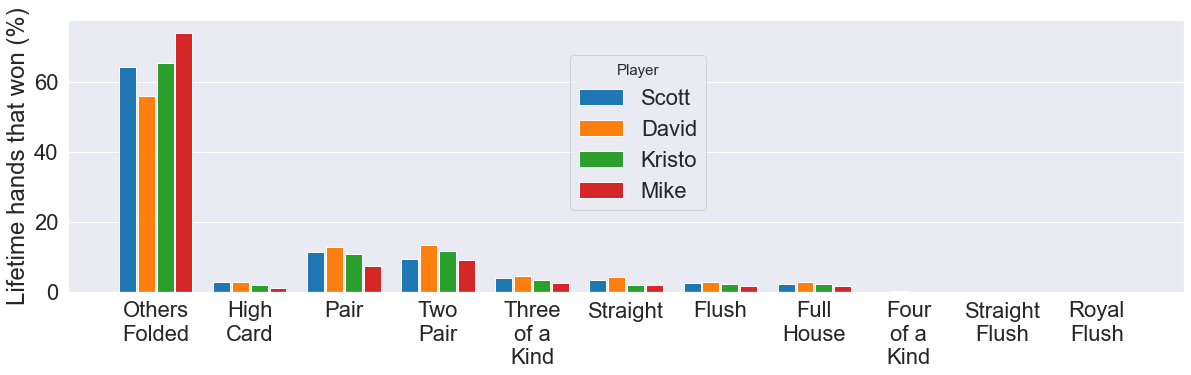

In [61]:
bar_plotter(dfsl_perc, save=True, fig_folder=fig_folder, ylabel='Lifetime hands that won (%)', filename='perc_lifetime_showdown.png', width=20)

- We can show the showdown hands without the "Others Folded" column, which will always likely be higher than the rest.

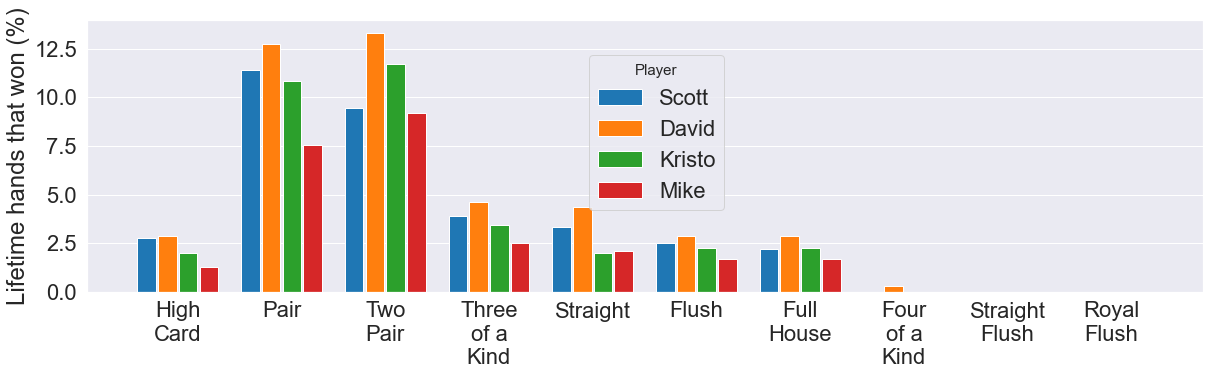

In [62]:
bar_plotter(dfsl_perc.drop(columns='Others\nFolded'),
            save=True,
            fig_folder=fig_folder,
            ylabel='Lifetime hands that won (%)',
            filename='perc_lifetime_showdown_no_fold.png', width=20)